# Loading the Datasets and Initial Commentary


In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud, STOPWORDS
from re import sub

There are a total of 7 datasets, one of which is a geojson file for the neighborhoods in New York. We will exclude it from the initial EDA since that dataset contains the geographical location of the neighborhoods, which is less interesting than the neighborhoods that the listings are in (we can get this data from the listings dataset). Therefore, we will load the remaining 6 datasets.

In [2]:
listings = pd.read_csv('./Data/listings.csv') 
reviews = pd.read_csv('./Data/reviews.csv')
reviews_full = pd.read_csv('./Data/reviews_full.csv')
listings_full = pd.read_csv('./Data/listings_full.csv')
neighborhood = pd.read_csv('./Data/neighbourhoods.csv')
calendar = pd.read_csv('./Data/calendar.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
neighborhood.shape

(230, 2)

In [4]:
data = listings_full.copy()
float_vars = data.loc[:, data.dtypes == 'float64']
int_vars = data.loc[:, data.dtypes == 'int64']
quantitative_vars = pd.concat([float_vars, int_vars], axis=1)
categorical_vars = data.loc[:, data.dtypes == object]

In [6]:
print(quantitative_vars.shape)
print(categorical_vars.shape)

(51097, 42)
(51097, 64)


## Listings Datasets

In [9]:
print(listings.shape)
listings.head()

(50599, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,10,48,2019-11-04,0.39,1,1
1,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,295,2019-11-22,4.67,1,1
2,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,78,2019-10-13,0.60,1,19
3,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,29,49,2017-10-05,0.38,1,365
4,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,454,2019-11-21,3.52,1,242


In [53]:
percent_NA = listings.isnull().sum() * 100 / len(listings)
NA_info = pd.DataFrame({'percent_NA': percent_NA})
print(NA_info)

                                percent_missing
id                                     0.000000
name                                   0.033598
host_id                                0.000000
host_name                              1.112670
neighbourhood_group                    0.000000
neighbourhood                          0.000000
latitude                               0.000000
longitude                              0.000000
room_type                              0.000000
price                                  0.000000
minimum_nights                         0.000000
number_of_reviews                      0.000000
last_review                           20.198028
reviews_per_month                     20.198028
calculated_host_listings_count         0.000000
availability_365                       0.000000


Unfortunately, there appears to be alot of missing data for last_review and reviews_per_month. While this is disappointing, we don't imagine these two variables to be critical variables in our model, especially because we have a full dataset of reviews for each listing. Most likely, the listings with NA's for these two variables had no reviews at all, which is something we can get from the reviews dataset.

In [7]:
print(listings_full.shape)
listings_full.head()

(51097, 106)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20200212052319,2020-02-12,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.39
1,3831,https://www.airbnb.com/rooms/3831,20200212052319,2020-02-13,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.69
2,5099,https://www.airbnb.com/rooms/5099,20200212052319,2020-02-12,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,...,f,f,moderate,t,t,1,1,0,0,0.59
3,5121,https://www.airbnb.com/rooms/5121,20200212052319,2020-02-12,BlissArtsSpace!,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.38
4,5178,https://www.airbnb.com/rooms/5178,20200212052319,2020-02-13,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"You will use one large, furnished, private roo...",Please don’t expect the luxury here just a bas...,none,"Theater district, many restaurants around here.",...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,3.53


In [20]:
percent_NA = listings_full.isnull().sum() * 100 / len(listings_full)
NA_info = pd.DataFrame({'percent_NA': percent_NA})
NA_info[NA_info["percent_NA"]>5]

,percent_NA
space,28.021215
neighborhood_overview,34.448206
notes,59.435975
transit,34.397323
access,46.904906
interaction,40.323307
house_rules,38.898565
thumbnail_url,100.000000
medium_url,100.000000
xl_picture_url,100.000000


Unfortunately, there seems to be several variables with significant amounts of missing data, such as thumbnail_url, jurisdiction_names, and monthly_price. Figuring out which variables we can drop and which variables we need to transform in some way will be a critical part of the data cleaning process. With the variables that have 100% missing data, we will have to drop those variables entirely.

#### Correlation Matrix

Since there are a few quantitative variables in this dataset, let's look at the correlations between some of these variables. From the smaller listings dataset, there are 6 quantitative variables that we can look at: price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, and availability_365.

In [5]:
names = ["price", "minimum_nights", "number_of_reviews", "reviews_per_month", 
         "calculated_host_listings_count", "availability_365"]

## create the correlation matrix

correlations = listings[names].corr()

matrix = pd.DataFrame(correlations, columns=names, index=names)
matrix = matrix.round(decimals=2)

matrix.style.background_gradient(cmap='RdYlGn')



,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
price,1,0.03,-0.04,-0.02,0.02,0.06
minimum_nights,0.03,1,-0.09,-0.13,0.12,0.15
number_of_reviews,-0.04,-0.09,1,0.56,-0.08,0.12
reviews_per_month,-0.02,-0.13,0.56,1,-0.04,0.18
calculated_host_listings_count,0.02,0.12,-0.08,-0.04,1,0.22
availability_365,0.06,0.15,0.12,0.18,0.22,1


From this, I can see that for this subset of 6 variables, there are no variables that are particularly strongly correlated. There does seem to be some moderate positive correlation between reviews_per_month and number_of_reviews, which makes sense. During our feature engineering process, we will look at all quantitative explanatory variables in the full dataset and consider the correlations between those variables.

#### Overall Remarks
It appears that the listings datasets have 50599 observations total. The full dataset contains 106 variables, including price, while the partial dataset only contains 16 variables, including price. Therefore, with the listings dataset, we have a total of 105 explanatory variables that we can use. That being said, some of these variables are likely to not be very useful in our model, with some examples being listing_url, scrape_id, and last_scraped. 

## Reviews Datasets

In [26]:
print(reviews.shape)
reviews.head()

(1255322, 2)


,listing_id,date
0,2595,2009-11-21
1,2595,2009-12-05
2,2595,2009-12-10
3,2595,2010-04-09
4,2595,2010-05-25


In [ ]:
percent_NA = listings_full.isnull().sum() * 100 / len(listings_full)
NA_info = pd.DataFrame({'percent_NA': percent_NA})
NA_info[NA_info["percent_NA"]>5]

In [29]:
print(reviews_full.shape)
reviews_full.head()

(1254654, 10)


,listing_id,id,date,reviewer_id,reviewer_name,comments,nwords,punc_prop,>2_exclamation,prop_cap
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...,123,0.029703,0,0.032532
1,2595,19176,2009-12-05,53267,Cate,Great experience.,2,0.058824,0,0.058824
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...,90,0.033970,0,0.036093
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en...",66,0.038251,0,0.024590
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...,24,0.025806,0,0.038710


In [60]:
percent_NA = reviews_full.isnull().sum() * 100 / len(reviews_full)
NA_info = pd.DataFrame({'percent_NA': percent_NA})
print(NA_info)

               percent_NA
listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000319
comments         0.053213


#### Overall Remarks

It appears that the partial reviews dataset only contains information on the listing ID and the date of review. The full reviews dataset is much more informative, with additional information such as review ID, reviewer ID, review name, and the text of the review. Luckily for us, there doesn't appear to be much missing data for the reviews. 5% of the reviews have missing information, which may say something about the experience itself, but we will figure out what to do with those missing reviews during the data cleaning process.

## Neighborhood and Calendar Datasets

In [49]:
print(neighborhood.shape)
neighborhood.head()

(230, 2)


,neighbourhood_group,neighbourhood
0,Bronx,Allerton
1,Bronx,Baychester
2,Bronx,Belmont
3,Bronx,Bronxdale
4,Bronx,Castle Hill


In [61]:
percent_NA = neighborhood.isnull().sum() * 100 / len(neighborhood)
NA_info = pd.DataFrame({'percent_NA': percent_NA})
print(NA_info)

                     percent_NA
neighbourhood_group         0.0
neighbourhood               0.0


The neighborhood dataset groups the neighborhood into one of five neighborhood groups (boroughs): Bronx, Brooklyn, Manhattan, Queens, and Staten Island. There's no missing information for this dataset, which makes sense. While we don't think this dataset will play a large role in our model considering the neighborhood of a listing is more informative than the borough that the listing is in, we will keep the availability of this information in mind as we create features that are pertinent to location/geography.

In [35]:
def to_num(x):
    x = re.sub(r',', '', x)
    return float(x[1:])

calendar.dropna(inplace = True)
calendar['price'] = list(map(to_num, calendar['price']))

def unique_listing(x):
    return len(np.unique(x))
calendar_summary = (
    calendar
    [['listing_id', 'date', 'price']]
    .groupby('date')
    .agg(
#         listing_count = ('listing_id', unique_listing),
        mean_price = ('price', np.mean)
    )
)

calendar_summary = calendar_summary.sort_values('date')

In [39]:
calendar_summary.head(50)

,mean_price
date,
2020-02-12,145.560027
2020-02-13,138.336328
2020-02-14,143.576483
2020-02-15,144.785502
2020-02-16,140.113923
2020-02-17,138.859226
2020-02-18,138.719274
2020-02-19,138.936668
2020-02-20,139.360146


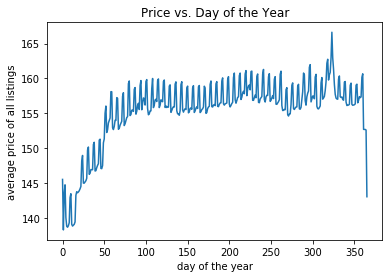

In [42]:
fig = plt.figure()
plt.plot(range(len(calendar_summary)), calendar_summary['mean_price'])
plt.xlabel('day of the year')
plt.ylabel('average price of all listings')
plt.title('Price vs. Day of the Year')
fig.savefig('plot2.png')

In [32]:
print(calendar.shape)
calendar.head()

(18650686, 7)


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,21456,2020-02-12,t,$99.00,$99.00,30.0,365.0
1,21456,2020-02-13,t,$99.00,$99.00,30.0,365.0
2,21456,2020-02-14,t,$99.00,$99.00,30.0,365.0
3,21456,2020-02-15,t,$99.00,$99.00,30.0,365.0
4,21456,2020-02-16,t,$99.00,$99.00,30.0,365.0


In [31]:
calendar.loc[:,"adjusted_price"].sort_values()

KeyboardInterrupt: 

In [19]:
sum(calendar.loc[:,"listing_id"] == 21456)

365

In [63]:
percent_NA = calendar.isnull().sum() * 100 / len(calendar)
NA_info = pd.DataFrame({'percent_NA': percent_NA})
print(NA_info)

                percent_NA
listing_id        0.000000
date              0.000000
available         0.000000
price             0.004856
adjusted_price    0.004856
minimum_nights    0.003557
maximum_nights    0.003557


For the calendar data, we have information on availability (occupancy), price, adjusted price, minimum nights, and maximum nights for a given listing on a given date. Luckily, there doesn't seem to be much missing information for this dataset, either. This information will be useful later on in the project when we project annual income from a listing, since this dataset will give us information on the price of listings throughout the year as well as their occupancy. That being said, there's not much information here worth exploring since we get price, minimum_nights, and maximum_nights in the listings dataset. The occupancy throughout the year, however, will be of key interest later on.

## Comments

In summary, there are a total of 7 files available for New York. 
1. neighborhoods.csv and neighborhoods.geojson: contains geographical information on neighborhoods in New York. 
2. listings.csv, listings_full.csv: contains 106 variables for each listing, including price.
3. reviews.csv, reviews_full.csv: contains information such as review text, reviewer ID, and listing ID.
4. calendar.csv: contains information on availability (occupancy), price, adjusted price, minimum nights, and maximum nights for a given listing on a given date

Overall, most of the datasets don't have much missing data. The one exception is listings_full.csv, which we will need to do significant data cleaning on and figure out what to do with the missing data. We would say the overall data quality is pretty good for the New York Airbnb datasets.

We believe the data on reviews and listings are the most interesting to explore, so we will do EDA on those datasets. We will use the other datasets (neighborhood, calendar info on listings) in some way when we fit our model.

# Listings

The condensed listings dataset contains 16 features that are useful for inital plotting: id, name, host_id, host_name, neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, last_review, reviews_per_month, calculated_host_listings_count, and availability_365. 

### Exploring the relationship between location, price, and number of listings

Intuitively, the nightly rate of a listing is likely to be correlated with the location of the listing. Also, the number of listings in a neighborhood may be associated with the neighborhood location, too. Furthermore, we imagine the nightly price may be related to the number of listings in the region due to the supply-demand dynamics. Therefore, we will visualize the relationship between location, price, and number of listings in the scatter plot below.

In [17]:
# prepare sub-group data for the plot of price against neighborhood location
data_neighbor_all = (
    listings
    .groupby("neighbourhood")
)

count_by_neighbor = data_neighbor_all["id"].count()
price_by_neighbor = data_neighbor_all["price"].agg(np.mean)
latitude_by_neighbor = data_neighbor_all["latitude"].agg(np.mean)
longitude_by_neighbor = data_neighbor_all["longitude"].agg(np.mean)

metric_by_neighbor = pd.DataFrame({
        "count" : count_by_neighbor,
        "price" : price_by_neighbor,
        "latitude": latitude_by_neighbor,
        "longitude": longitude_by_neighbor
    }
)

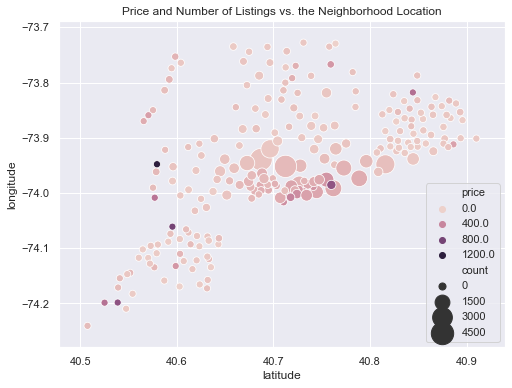

In [18]:
sns.set(color_codes=True)
plt.figure(figsize=(8,6))
plot1 = sns.scatterplot(data = metric_by_neighbor, x = "latitude", y = "longitude"
                        ,hue = "price" 
                        ,size = "count"
                        ,sizes = (50,500)
                       )
plot1.set_title("Price and Number of Listings vs. the Neighborhood Location")
plot1.legend(loc = "lower right")

Let's now check the exact neighborhoods that have the most expensive listings or the highest number of listings.

In [19]:
print(metric_by_neighbor["price"].sort_values(ascending = False).head(), end = '\n\n')
print(metric_by_neighbor["count"].sort_values(ascending = False).head())

neighbourhood
Manhattan Beach     1098.800000
Fort Wadsworth       800.000000
Woodrow              700.000000
Theater District     690.763754
Country Club         525.000000
Name: price, dtype: float64

neighbourhood
Bedford-Stuyvesant    3974
Williamsburg          3936
Harlem                2746
Bushwick              2504
Hell's Kitchen        2052
Name: count, dtype: int64


Surprisingly, listings in Manhattan Beach (in Brooklyn) have the highest average listing price, whereas Bedford-Stuyvesant provides the largest number of listings. 

### Distributions of number of bedrooms, bathrooms, guests to be accommodated, and the number beds

The number of bedrooms, bathrooms, guests to be accommodated, and the number of beds are also potential features of a listing that can impact the price. Hence, we want to have a first glance of these four variables. 

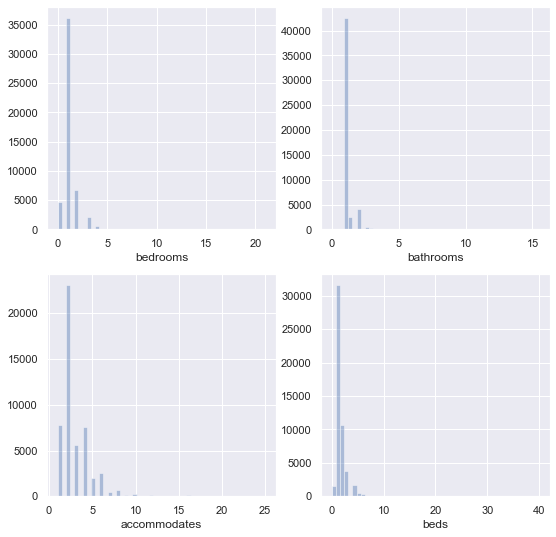

In [21]:
plt.figure(figsize=(9,9))
plt.subplot(221)
sns.distplot(listings_full["bedrooms"].dropna(), kde=False)
plt.subplot(222)
sns.distplot(listings_full["bathrooms"].dropna(), kde=False)
plt.subplot(223)
sns.distplot(listings_full["accommodates"].dropna(), kde=False)
plt.subplot(224)
sns.distplot(listings_full["beds"].dropna(), kde=False)

Looking at the distributions, it appears that in general, most values of these quantities are below 5 while outliers exist in each of these variables. As such, we might consider excluding the outliers when creating our models.

### Price vs. Number of Reviews 

We think the number of reviews for a listing should also impact its price, so let's explore that relationship now.

Text(0.5, 1.0, 'Price vs. Number of reviews')

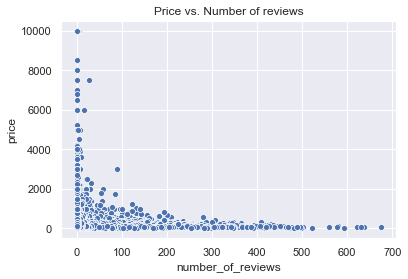

In [35]:
sns.scatterplot(x = listings["number_of_reviews"], y = listings["price"])
plt.title('Price vs. Number of reviews')

In the scatterplot, we can see that as the number of reviews increases, the price actually decreases, which was contrary to our initial expectation. One possible reason for this is that when the price of a listing is extremely high, fewer people are willing to rent that listing, and conversely, cheaper listings will be more popular and thus have more reviews.

### Price vs. Reviews per Month

One concern with the previous plot is that older listings may have more reviews, but the age of listing likely doesn't have any impact on the price. Therefore, we also want to look at the relationship between price and reviews per month. Ideally, we should observe the same relationship as price and number of reviews.

Text(0.5, 1.0, 'Price vs. Reviews per month')

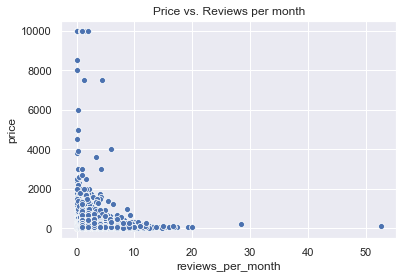

In [38]:
sns.scatterplot(x = listings["reviews_per_month"], y = listings["price"])
plt.title('Price vs. Reviews per month')

As it turns out, we observe a similar pattern to the previous scatter plot (price vs. number of reviews), where the price decreases as the number of reviews per month increase, which is what we expected (and hoped) we would observe.

### Listing Types

One interesting feature in the listings dataset is the type of listing. The listing can fall into four different categories: entire home/apartment, private room, shared room, and hotel room. Let's look at the distribution of listing types.

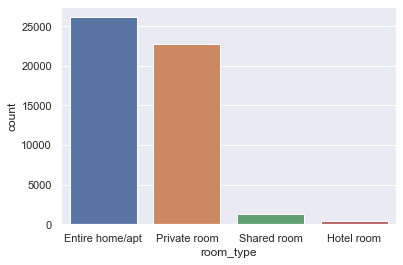

In [33]:
sns.set_style('darkgrid')
sns.countplot(listings['room_type'])

In the plot, we can see that the "Entire home/apt" and "Private room" listing types are the most popular by far while the "Shared room" and "Hotel room" listings are much lower in frequency. From this, we can infer that our dataset is dominated by listings that are entire homes/apartments or private rooms in a home/apartment.

# Reviews

The full reviews dataset contains 6 features: listing_id, review id, date, reviewer_id, reviewer_name, and comments. We will create new features based on the comments and do EDA on those features. Here are the features we made:

1. nwords: the number of words on the review
2. punc_prop: the proportion of punctuations used in a comment
3. excl: whether or not there are more than 2 exclamation points in a row in a comment
4. propC: the proportion of capitalized letters in a comment.

We believe these features will give us insights into the nature of the reviews and could reflect certain qualities that may be helpful to our model later. 

Furthermore, one of our goals in this project is to create a sentiment score for each review, and use those scores as a predictor for listing income. Since our data is unlabeled by nature, we need to use an unsupervised learning algorithm to first categorize the data into (roughly) three groups of positive, negative and neutral sentiments. To accomplish that, we created a word cloud, which we will use later in our sentiment score assignments. 

In [3]:
## drop observations in the datset with no reviews
reviews_full = reviews_full.dropna(subset=["comments"])
reviews_full.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...


### Feature 1: Number of Words

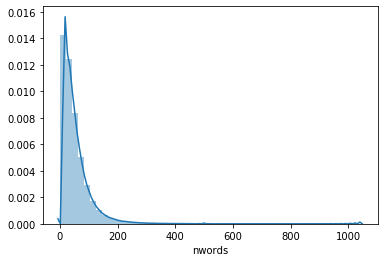

In [4]:
## count the length of a review in terms of number of words
def count_words(string):
    return len(string.split())

reviews_full["nwords"] = reviews_full["comments"].apply(count_words)
sns.distplot(reviews_full["nwords"])

Not surprisingly, the distribution of comments is highly right skewed, and most comments seem to be fewer than 200 words long.

### Feature 2: Proportion of punctuations

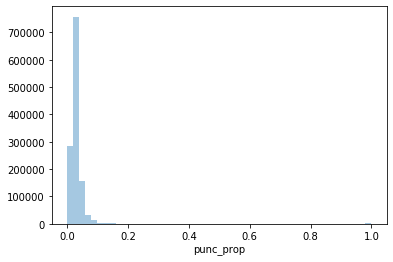

In [5]:
## returns the proportion of punctuation marks in the comment
def prop_punc(input_str):
    return len(re.findall(f"[{string.punctuation}]", input_str))/len(input_str)

reviews_full["punc_prop"] = reviews_full["comments"].apply(prop_punc)
sns.distplot(reviews_full["punc_prop"], kde=False)

In [7]:
reviews_full["comments"][reviews_full["punc_prop"]>.6]

301         .
2361        .
3752       :)
5960       ..
14351       .
           ..
1249935     .
1250789     .
1253146     .
1253249     .
1255242     .
Name: comments, Length: 1435, dtype: object

It appears that there are quite a few "reviews" that contain only punctuation marks. We can interpret this as some kind of empty review (since I'm assuming the users put these "reviews" in because Airbnb required them to comment on the accomodation in some way). The fact that these users left these "empty" reviews may say something about the accomodation or the host, so we will keep this in mind as we build our model.

The nightly rate of a listing is highly likely to correlated with the location of the listing. The number of listings in a neighborhood may be associated with the neighborhood location, too. Furthermore, we imagine the nightly price may be related to the number of listings in the region due to the supply-demand dynamics. Therefore, we will visualize the relationship between location, price, and number of listings in the scatter plot below.

### Feature 3: More than 2 exclamation points in a row 

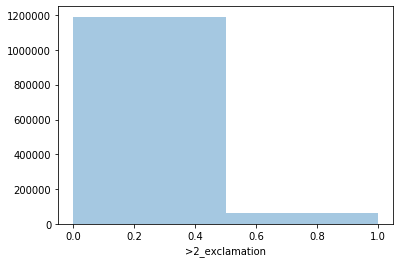

In [8]:
## returns 1 if there is more than 2 exclamation marks in a row in the review
def excl(input_str):
    return int(len(re.findall("!!(.*)", input_str))>0)

reviews_full[">2_exclamation"] = reviews_full["comments"].apply(excl)
sns.distplot(reviews_full[">2_exclamation"], kde=False, bins=2)

In [9]:
print(sum(reviews_full[">2_exclamation"] == 1)) # number of reviews with more than 2 exclamation marks
print(sum(reviews_full[">2_exclamation"] == 1)/len(reviews_full)) # proportion of reviews

64276
0.05123006023971549


As expected, most reviews don't include more than 2 exclamation marks in a row, but of the over 1.2 million reviews, 64,276 comments do, which makes it a nontrivial proportion ($\approx 5\%$) of the total reviews. 

### Feature 4: Proportion of capitalized letters


[(0, 0.3)]

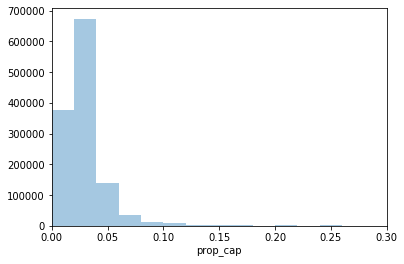

In [10]:
upper = re.compile('[A-Z]')

def prop_cap(input_str):
    return len(upper.findall(input_str))/len(input_str)

reviews_full["prop_cap"] = reviews_full["comments"].apply(prop_cap)

hist = sns.distplot(reviews_full["prop_cap"], kde=False)
hist.set(xlim=(0, .3))

It appears that most reviews don't have over 10% capitalized letters. However, those reviews that do have over 10% capitalized letters might say something about the accomodation or the host, so we will keep this feature in mind when we build our model.

## Word Cloud

Again, in order to assign a sentiment score to the reviews, we need to know what positive/negative words are there in a sentence, so we will create a word cloud to understand what kinds of words exist in our data.

In [11]:
comments = reviews_full.comments.dropna()
comments.head()

0    Notre séjour de trois nuits.\r\nNous avons app...
1                                    Great experience.
2    I've stayed with my friend at the Midtown Cast...
3    We've been staying here for about 9 nights, en...
4    We had a wonderful stay at Jennifer's charming...
Name: comments, dtype: object

We see there are not only English comments in the dataset (which is normal considering the size of New York). For the purpose of analysis, we now drop the comments that are non-English:

In [12]:
## return true if string is detected as English
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [13]:
def clean(s):
    s = sub(r"[,!?.\/)('‘’“”+-:;–—\r\n\t\xa0]", " ", s)
    return (s)

comments = comments.apply(clean) # Perform data cleaning to avoid false positives for English

In [14]:
comments.loc[comments.apply(isEnglish)==False] # Non-English comments to be dropped

0          Notre séjour de trois nuits   Nous avons appré...
21         Tiene una ubicación excelente  Buen equipamien...
33         Jennifer es un anfitrión increíble  Siempre es...
53         Lisa était sympa  toujours prête à aider  L ét...
58         Bien que la chambre soit défraichi  nous avons...
                                 ...                        
1255194    Un lugar muy tranquilo  La anfitriona fue muy ...
1255214    Excelente lugar  Sin dudas nos quedaríamos ahí...
1255222    Lovely touch when we arrive  ❤️  Amazing place...
1255231                 Хорошо  но райончик стремноватенький
1255244    Buen lugar todo ordenado y  privado además par...
Name: comments, Length: 137219, dtype: object

Some reviews that contain emoji's that are hard to detect using regular expressions. We decide to drop them nonetheless, as our false discovery rate should be low anyways.

In [15]:
eng_comments = comments.loc[comments.apply(isEnglish)] # just the English comments
text = eng_comments.str.cat(sep = ' ').lower()

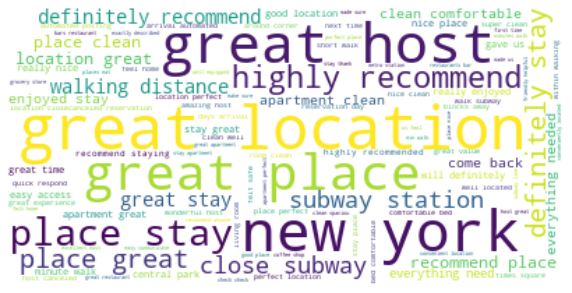

In [16]:
## Generate the word cloud

wc = WordCloud(background_color="white", repeat=False, stopwords=set(STOPWORDS))
wc.generate(text)

fig = plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
fig.savefig('wordcloud.png', dpi = fig.dpi)
plt.show()

Finally, we managed to pull a word cloud, which gives us an intuition of the distribution of words.

- Positive: There is a majority of good words such as 'great host', 'great location', 'recommend', 'clean';

- Neutral: There are neutral words featuring objective things such as 'New York', 'subway station', 'central park';

- Negative: The frequency of bad words is low. Though, we found posts like below which supposingly conveys negative emotions: